In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
!pip install distython
!pip install stop_words

In [124]:
import pandas as pd
import json
import os
import re
import random
from scipy import sparse
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from distython import HEOM
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from stop_words import get_stop_words
import gensim
from nltk.stem import WordNetLemmatizer

import pickle
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, Normalizer
from sklearn.cluster import AgglomerativeClustering, KMeans

from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split

# Preprocessing Data


In [125]:
songId_song_map = {}
songId_artist_map = {}
track_playlist_map = {}
playlists_name = []
all_playlists = []

train_list = []
test_list = []
list_song_num = {}
vocabulary = {}

In [126]:
# read json files

def process_mpd(path, filter=False):
  global test
  f = open('/content/drive/MyDrive/240_project/data_0_50000/mpd.slice.0-999.json')
  js = f.read()
  f.close()
  slice = json.loads(js)
  for playlist in slice['playlists']:
    all_playlists.append(playlist)
  list_train, list_test = train_test_split(all_playlists, test_size=0.05, shuffle=True, random_state=42)
  test=pd.DataFrame(list_test)
  process_playlist(list_train, train_list, filter)
  process_playlist(list_test, test_list, filter)


In [127]:
def process_playlist(playlist, save_list, filter):
  # only keep playlists length between 10 - 250 
  # remove all duplicate traks in each playlist
  min_tracks_per_playlist = 10
  max_tracks_per_playlist = 100
  for item in playlist:
    # process the songs in the list
    temp = []
    if filter:
      if item['num_tracks'] < min_tracks_per_playlist or \
          item['num_tracks'] > max_tracks_per_playlist:
        continue
    
    # check how many songs in a playlist
    num = item['num_tracks']
    list_song_num[num] = list_song_num.get(num, 0) + 1

    for track in item['tracks']:
      song_uri = track['track_uri'].split(':')[2]
      # map track id to track name
      song_name = track['track_name']
      songId_song_map[song_uri] = song_name
      # map songId and artist
      song_artist = track['artist_name']
      songId_artist_map[song_uri] = song_artist
      # add song to list
      temp.append(song_uri)
      # remove duplicate songs
      res = []
      [res.append(x) for x in temp if x not in res]

    # add list to playlists
    save_list.append(res)

In [128]:
def song2id(song_art_dict):
  songIds = []
  song_names = song_art_dict.keys()
  for song in song_names:
    tempIds = []
    artist = song_art_dict[song]
    for key, value in songId_song_map.items():
      if song == value:
        tempIds.append(key)
    for id in tempIds:
      if songId_artist_map[id] == artist:
        songIds.append(id)
        break
  return songIds

In [129]:
path = '/content/drive/MyDrive/240_project/data_0_50000/'
process_mpd(path, filter=True)


In [130]:
test.head

<bound method NDFrame.head of                    name collaborative  ...  num_artists             description
0                 music         false  ...           85                     NaN
1                 fuego         false  ...           26                     NaN
2                  will         false  ...           72                     NaN
3                 Panda         false  ...           25                     NaN
4                ashley         false  ...          104                     NaN
5                    tb         false  ...            5                     NaN
6         teenage angst         false  ...           53  closeted hypochondriac
7               Sunrise         false  ...           36                     NaN
8              Hungover         false  ...          117                     NaN
9                   Rap         false  ...           22                     NaN
10             musicals         false  ...           59                     NaN
11        

In [131]:
dirPath = '/content/drive/MyDrive/240_project/data_0_50000/'
path = '/content/drive/MyDrive/240_project/data_0_50000/'

files = os.listdir(dirPath)
sorted(files)

# Chnage this number if needed 
number_of_json_file = 1
playlist_frames = []

for i in range(number_of_json_file):
    data = json.load(open(dirPath+files[i]))
    df = pd.DataFrame(data['playlists'])
    playlist_frames.append(df)

data = pd.concat(playlist_frames)


In [132]:
data.shape
test.shape

(50, 12)

In [133]:
data.drop(['collaborative','modified_at','num_edits','description'], axis=1, inplace=True)
test.drop(['collaborative','modified_at','num_edits','description'], axis=1, inplace=True)

In [134]:
data.head()

,name,pid,num_tracks,num_albums,num_followers,tracks,duration_ms,num_artists
0,Throwbacks,0,52,47,1,"[{'pos': 0, 'artist_name': 'Missy Elliott', 't...",11532414,37
1,Awesome Playlist,1,39,23,1,"[{'pos': 0, 'artist_name': 'Survivor', 'track_...",11656470,21
2,korean,2,64,51,1,"[{'pos': 0, 'artist_name': 'Hoody', 'track_uri...",14039958,31
3,mat,3,126,107,1,"[{'pos': 0, 'artist_name': 'Camille Saint-Saën...",28926058,86
4,90s,4,17,16,2,"[{'pos': 0, 'artist_name': 'The Smashing Pumpk...",4335282,16


In [135]:
test.head()

,name,pid,num_tracks,num_albums,num_followers,tracks,duration_ms,num_artists
0,music,521,127,108,1,"[{'pos': 0, 'artist_name': 'Charli XCX', 'trac...",27364349,85
1,fuego,737,35,29,1,"[{'pos': 0, 'artist_name': 'Dropout', 'track_u...",7650968,26
2,will,740,195,137,3,"[{'pos': 0, 'artist_name': 'Lynyrd Skynyrd', '...",49344651,72
3,Panda,660,91,53,2,"[{'pos': 0, 'artist_name': 'Memphis May Fire',...",19777780,25
4,ashley,411,169,135,1,"[{'pos': 0, 'artist_name': 'Sia', 'track_uri':...",37973952,104


In [136]:
print('Before filtering out unexpected playlist, total number of unique songs is: ', len(songId_song_map.keys()))

Before filtering out unexpected playlist, total number of unique songs is:  19581


In [137]:
print('Before filtering out unexpected playlist, total number of playlists is: ', len(all_playlists))

Before filtering out unexpected playlist, total number of playlists is:  1000


In [138]:
print('Number of train playlists:', len(train_list))
print('Number of test playlists:', len(test_list))

Number of train playlists: 703
Number of test playlists: 35


In [139]:
# save dataset
with open('/content/drive/MyDrive/240_project/Code/kmeans/train1000.txt', 'w') as f:
  f.write('\n'.join([' '.join(i) for i in train_list]))
f.close()

with open('/content/drive/MyDrive/240_project/Code/kmeans/test1000.txt', 'w') as f:
  f.write('\n'.join([' '.join(i) for i in test_list]))
f.close()

In [140]:
tracks_frame = []

for index, row in data.iterrows():
  t = pd.DataFrame(row['tracks'])
  t['num_followers'] = row['num_followers']
  t.drop(['pos','artist_uri','album_uri','duration_ms'], axis=1, inplace=True)
  tracks_frame.append(t)
    
tracks_data = pd.concat(tracks_frame)   

In [148]:
test_tracks_frame = []

for index, row in test.iterrows():
    t = pd.DataFrame(row['tracks'])
    t['pl_name']=row['name']
    t['num_followers'] = row['num_followers']
    t.drop(['pos','artist_uri','album_uri','duration_ms'], axis=1, inplace=True)
    test_tracks_frame.append(t)
    
test_tracks_data = pd.concat(test_tracks_frame)   

In [142]:
test_tracks_data.count

<bound method DataFrame.count of          artist_name  ... num_followers
0         Charli XCX  ...             1
1   The Chainsmokers  ...             1
2                MAX  ...             1
3        Post Malone  ...             1
4                AJR  ...             1
..               ...  ...           ...
13        Faith Hill  ...             1
14   Little Big Town  ...             1
15      Canaan Smith  ...             1
16   Miranda Lambert  ...             1
17        Sara Evans  ...             1

[3668 rows x 6 columns]>

In [143]:
follower_count = pd.DataFrame(tracks_data.groupby('track_uri')['num_followers'].sum())
tracks_data.drop('num_followers',axis=1,inplace=True)
tracks_data.drop_duplicates(inplace=True)
tracks_data.set_index('track_uri', inplace=True)
tracks_data = pd.concat([tracks_data,follower_count],axis=1)

In [149]:
test_follower_count = pd.DataFrame(test_tracks_data.groupby('track_uri')['num_followers'].sum())
test_tracks_data.drop('num_followers',axis=1,inplace=True)
test_tracks_data.drop_duplicates(inplace=True)
test_tracks_data.set_index('track_uri', inplace=True)
test_follower_count.head
test_tracks_data.head
#test_tracks_data = pd.concat([test_tracks_data,test_follower_count],axis=1)


<bound method NDFrame.head of                                            artist_name  ...      pl_name
track_uri                                               ...             
spotify:track:0y8Wf6ltWpGCpgqVa21QNX        Charli XCX  ...        music
spotify:track:6RUKPb4LETWmmr3iAEQktW  The Chainsmokers  ...        music
spotify:track:1sYSP7gKa5kdKIfhANfori               MAX  ...        music
spotify:track:3a1lNhkSLSkpJE4MSHpDu9       Post Malone  ...        music
spotify:track:3E2Zh20GDCR9B1EYjfXWyv               AJR  ...        music
...                                                ...  ...          ...
spotify:track:0TxXEbxn52XsuAhxb6VFZw        Faith Hill  ...  Country Mix
spotify:track:7hKpnp7A7bjiZEyywa5Qn4   Little Big Town  ...  Country Mix
spotify:track:2QVzUws1l5mzZ4v46tGHrC      Canaan Smith  ...  Country Mix
spotify:track:6s9m5J92By7jii22Q2XtY2   Miranda Lambert  ...  Country Mix
spotify:track:6Zf4AMWgnUDobtAixiIqnZ        Sara Evans  ...  Country Mix

[3640 rows x 4 colum

In [ ]:
tracks_data.shape


(34443, 4)

In [ ]:
test_tracks_data.shape

(3640, 4)

## Combine track_name and album_name

In [150]:
tracks_data['documents'] = tracks_data['track_name'].apply(lambda s: s.lower()) + ' ' + tracks_data['album_name'].apply(lambda s: s.lower())
test_tracks_data['documents'] = test_tracks_data['track_name'].apply(lambda s: s.lower()) + ' ' + test_tracks_data['album_name'].apply(lambda s: s.lower())

In [151]:
def lemmatization(words):
    lemmatizer = WordNetLemmatizer()
    result = []
    for word in words.split(' '):
        result.append(lemmatizer.lemmatize(word))
    return ' '.join(result)

def remove_stopword(words):
    result = []
    sw = list(STOPWORDS) + stopwords.words('english') + get_stop_words('english') + list(gensim.parsing.preprocessing.STOPWORDS)
    for word in words.split(' '):
        if word not in sw:
            result.append(word)
    return ' '.join(result)

def remove_single_and_two_characters(words):
    result = []
    for word in words.split(' '):
        if len(word) > 2:
            result.append(word)
    return ' '.join(result)  

def remove_any_numbers_besides_year(words):
    result = []
    for word in words.split(' '):
        if not word.isnumeric() or len(word) == 4:
            result.append(word)
    return ' '.join(result)

In [152]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [153]:
tracks_data['documents'] = tracks_data['documents'].apply(lemmatization)
tracks_data['documents'] = tracks_data['documents'].apply(remove_stopword)
tracks_data['documents'] = tracks_data['documents'].apply(lambda s: re.sub(r'[^a-z0-9]',' ',s))
tracks_data['documents'] = tracks_data['documents'].apply(remove_single_and_two_characters)
tracks_data['documents'] = tracks_data['documents'].apply(remove_any_numbers_besides_year)

In [154]:
test_tracks_data['documents'] = test_tracks_data['documents'].apply(lemmatization)
test_tracks_data['documents'] = test_tracks_data['documents'].apply(remove_stopword)
test_tracks_data['documents'] = test_tracks_data['documents'].apply(lambda s: re.sub(r'[^a-z0-9]',' ',s))
test_tracks_data['documents'] = test_tracks_data['documents'].apply(remove_single_and_two_characters)
test_tracks_data['documents'] = test_tracks_data['documents'].apply(remove_any_numbers_besides_year)

### Drop the rows with empty string after preprocessing words

In [155]:
d = tracks_data['documents'].apply(len).to_dict()
t = dict(filter(lambda x: x[1]==0,d.items()))

tracks_data = tracks_data.drop(list(t.keys()))
tracks_data.shape

(34023, 5)

In [156]:
d = test_tracks_data['documents'].apply(len).to_dict()
t = dict(filter(lambda x: x[1]==0,d.items()))

test_tracks_data = test_tracks_data.drop(list(t.keys()))
test_tracks_data.shape

(3586, 5)

### Save preprocessed dataset to csv

In [157]:
tracks_data.head()

,artist_name,track_name,album_name,num_followers,documents
spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),The Cookbook,7,lose control feat ciara fat man scoop cookbook
spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,Toxic,In The Zone,16,toxic zone
spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,Crazy In Love,Dangerously In Love (Alben für die Ewigkeit),49,crazy love dangerously love alben die ewigkeit
spotify:track:1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,Rock Your Body,Justified,14,rock body justified
spotify:track:1lzr43nnXAijIGYnCT8M8H,Shaggy,It Wasn't Me,Hot Shot,43,hot shot


In [158]:
test_tracks_data.head()

,artist_name,track_name,album_name,pl_name,documents
track_uri,,,,,
spotify:track:0y8Wf6ltWpGCpgqVa21QNX,Charli XCX,After The Afterparty (feat. Lil Yachty),After The Afterparty (feat. Lil Yachty),music,afterparty feat lil yachty afterparty feat lil...
spotify:track:6RUKPb4LETWmmr3iAEQktW,The Chainsmokers,Something Just Like This,Memories...Do Not Open,music,memories open
spotify:track:1sYSP7gKa5kdKIfhANfori,MAX,Lights Down Low,Hell's Kitchen Angel,music,light low hell kitchen angel
spotify:track:3a1lNhkSLSkpJE4MSHpDu9,Post Malone,Congratulations,Stoney,music,congratulation stoney
spotify:track:3E2Zh20GDCR9B1EYjfXWyv,AJR,Weak,The Click,music,weak click


In [ ]:
tracks_data.to_csv('data/preprocessed_dataset.csv')


In [159]:
test_tracks_data.to_csv('/content/drive/MyDrive/240_project/Code/kmeans/preprocessed_test_dataset.csv')

# Feature Engineering 

In [ ]:
tracks_data = pd.read_csv('/content/drive/MyDrive/240_project/Code/kmeans/preprocessed_dataset.csv')
tracks_data.set_index('track_uri', inplace=True)

In [ ]:
tracks_data = pd.read_csv('/content/drive/MyDrive/240_project/Code/kmeans/preprocessed_dataset.csv')
tracks_data.set_index('track_uri', inplace=True)

In [ ]:
def get_cos_matrix(X):
    cos_matrix = []
    for i in range(X.shape[0]):
        m = cosine_similarity(X[i],X[:])
        cos_matrix.append(m.flatten().tolist())
    return np.round(cos_matrix,4)

## Generate Features from track_name and album_name

In [ ]:
all_words = " ".join(tracks_data['documents'].tolist())
freq_count = Counter(all_words.split(' '))
sorted(freq_count.items(),key=lambda x: x[1],reverse=True)[0:10]

[('feat', 2218),
 ('love', 2015),
 ('version', 1262),
 ('remix', 1213),
 ('live', 1066),
 ('original', 749),
 ('night', 729),
 ('time', 677),
 ('life', 652),
 ('remastered', 631)]

In [ ]:
min_freq = int(np.percentile(list(freq_count.values()),95))

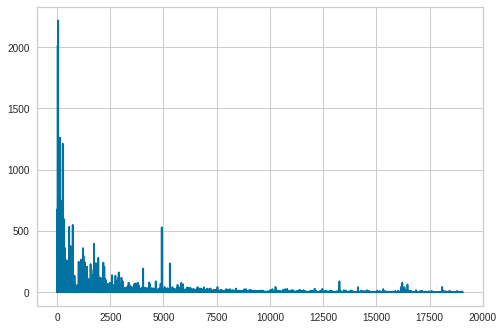

In [ ]:
plt.plot(list(freq_count.values()))
plt.show()

In [ ]:
vectorizer = TfidfVectorizer(min_df=min_freq)
X_documents = vectorizer.fit_transform(tracks_data['documents'])
X_documents = np.round(X_documents,4)

In [ ]:
X_documents.shape

(35264, 897)

In [ ]:
X = X_documents.todense()

In [ ]:
# Take very long time to run this (about 2 mins for 1000 rows)
SIM_matrix = get_cos_matrix(X)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarn

# Estimate Number of Clusters for KMeans

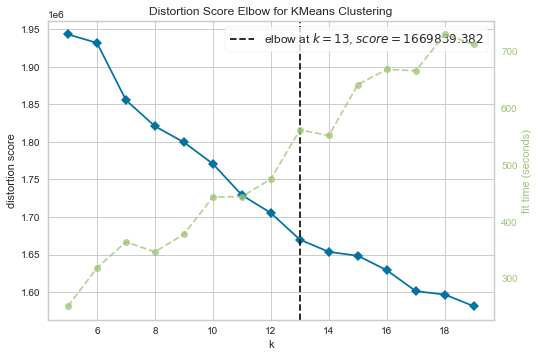

In [ ]:
model = KMeans(init='k-means++',random_state=0)
visualizer = KElbowVisualizer(model, k=(5,20))
visualizer.fit(SIM_matrix)
visualizer.poof()
k = visualizer.elbow_value_

# Build KMeans 

In [ ]:
model = KMeans(n_clusters=k,init='k-means++',random_state=0).fit(SIM_matrix)

In [ ]:
pickle.dump(model, open('kmeans_mode_nlp.sav', 'wb'))